# # 🧬 The Cell Traffic Controller: Model Training
# This notebook cleans UniProt data, extracts bio-features, and trains a Random Forest.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- CONFIGURATION ---
DATASET_CHOICE = 'unreviewed' # 'reviewed' or 'unreviewed'
FILES = {
    'reviewed': 'data.tsv',
    'unreviewed': 'data2.tsv'
}

print(f"⚙️ Configuration: Building model using [{DATASET_CHOICE.upper()}] data.")


⚙️ Configuration: Building model using [UNREVIEWED] data.


In [2]:
HYDRO_SCALE = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8, 
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8, 
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5, 
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

# --- 2. Mathematical Helper Function ---
def calculate_segment_properties(seq_segment):
    """
    Calculates Hydrophobicity and Charge for ANY given string segment.
    Returns tuple: (avg_hydrophobicity, fraction_positive_charge)
    """
    length = len(seq_segment)
    
    # Avoid Division by Zero without messy nested ifs
    if length == 0:
        return 0.0, 0.0
    
    # Calculate properties
    hydro = sum([HYDRO_SCALE.get(aa, 0) for aa in seq_segment]) / length
    charge = (seq_segment.count('K') + seq_segment.count('R')) / length
    
    return hydro, charge

# --- 3. Main Feature Extractor ---
def get_protein_features(seq):
    if not isinstance(seq, str): return None
    seq = seq.upper().strip()
    L = len(seq)
    if L == 0: return None
    
    features = {}
    
    # --- A. Global Features ---
    features["Length"] = L
    
    # Amino Acid Composition (The "Vibe")
    for aa in "ACDEFGHIKLMNPQRSTVWY":
        features[f"Global_{aa}"] = seq.count(aa) / L
        
    features["Global_Hydro"], _ = calculate_segment_properties(seq)

    # --- B. N-Terminus Scanning (The Signal) ---
    # We use specific windows to capture Signal Peptides (avg 20-30aa) 
    # and Mitochondrial signals (avg 20-60aa).
    # Python slicing [:N] automatically handles cases where len < N.
    scan_windows = [20, 40, 60]
    
    for w in scan_windows:
        segment = seq[:w]
        hydro, charge = calculate_segment_properties(segment)
        features[f"N{w}_Hydro"] = hydro
        features[f"N{w}_Charge"] = charge

    # --- C. C-Terminus Scanning (The Tail) ---
    # Often contains retention signals (e.g., KDEL for ER, though we simplify here)
    c_segment = seq[-20:]
    hydro, charge = calculate_segment_properties(c_segment)
    features["C20_Hydro"] = hydro
    features["C20_Charge"] = charge

    return features

# --- 4. Label Cleaning ---
def simplify_location_advanced(text):
    if not isinstance(text, str): return None
    text = text.lower()
    
    mapping = {
        "mitochondrion": "Mitochondria",
        "nucleus": "Nucleus",
        "cytoplasm": "Cytoplasm",
        "cell membrane": "Cell Membrane",
        "secreted": "Secreted",
        "extracellular space": "Secreted"
    }
    
    matches = set()
    for key, val in mapping.items():
        if key in text:
            matches.add(val)
            
    # Membrane priority: If both Membrane and Secreted, usually Membrane wins
    if "Cell Membrane" in matches: return "Cell Membrane"
    if len(matches) == 1: return list(matches)[0]
    
    return None


In [3]:
# Load data
file_path = FILES[DATASET_CHOICE]
print(f"📂 Loading {file_path}...")
df = pd.read_csv(file_path, sep='\t')

# Apply Cleaning
df['Target'] = df['Subcellular location [CC]'].apply(simplify_location_advanced)
df_clean = df.dropna(subset=['Target', 'Sequence'])

if DATASET_CHOICE == 'reviewed':
    df_clean = df_clean.drop_duplicates(subset=['Sequence'])

print(f"✅ Final Training Set: {len(df_clean)} sequences")
print(df_clean['Target'].value_counts())

📂 Loading data2.tsv...
✅ Final Training Set: 67087 sequences
Target
Cell Membrane    32489
Mitochondria     13728
Nucleus           9857
Cytoplasm         8200
Secreted          2813
Name: count, dtype: int64


In [4]:
print("🧪 Extracting structured features...")
# Apply the feature extraction
feature_list = df_clean['Sequence'].apply(get_protein_features).tolist()
X = pd.DataFrame(feature_list)
y = df_clean['Target'].reset_index(drop=True)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
print("🧠 Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"🏆 Accuracy: {acc:.2%}")
print("\n" + classification_report(y_test, y_pred))



🧪 Extracting structured features...
🧠 Training Random Forest...
🏆 Accuracy: 90.09%

               precision    recall  f1-score   support

Cell Membrane       0.95      0.97      0.96      6537
    Cytoplasm       0.75      0.75      0.75      1690
 Mitochondria       0.99      0.93      0.96      2704
      Nucleus       0.77      0.86      0.81      1920
     Secreted       0.91      0.60      0.72       567

     accuracy                           0.90     13418
    macro avg       0.87      0.82      0.84     13418
 weighted avg       0.90      0.90      0.90     13418



💾 Model saved successfully.


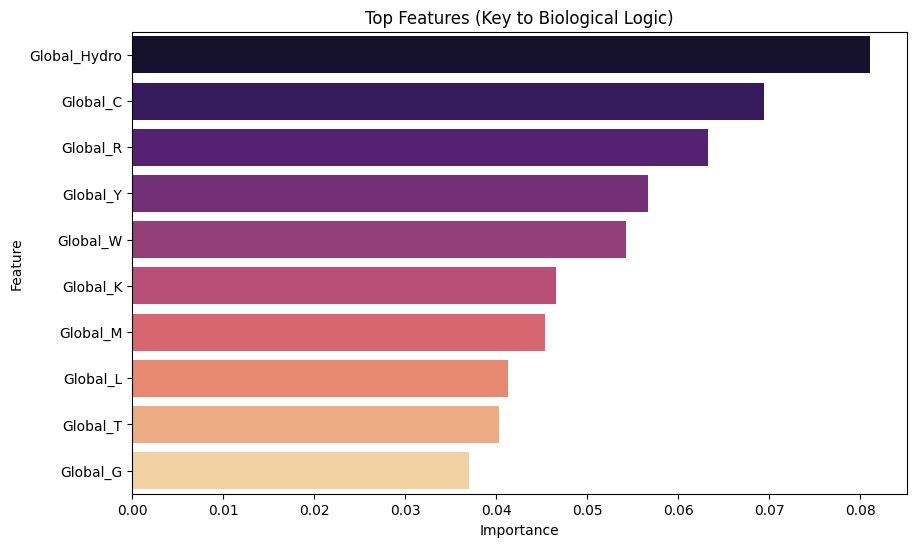

In [5]:
joblib.dump(rf_model, 'cell_traffic_model.pkl')
joblib.dump(X.columns.tolist(), 'model_features.pkl')
print("💾 Model saved successfully.")

# Visualize Importance
importances = rf_model.feature_importances_
feat_viz = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_viz = feat_viz.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_viz, hue='Feature', palette='magma', legend=False)
plt.title(f'Top Features (Key to Biological Logic)')
plt.show()
